In [1]:
from pandas import *
from math import *
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline


In [2]:
# Read the csv
pcap_main = read_csv('./lab-pc/trace1/test.csv', index_col=None, encoding='utf-8')
pcap_main.head()


,No.,Time,Source,Destination,Protocol,Length,ssl_len,Info
0,1,0.000000,SuperMic_dc:ba:c7,Broadcast,ARP,60,NaN,Who has 192.168.1.163? Tell 192.168.1.248
1,2,0.156770,192.168.1.108,224.0.0.251,MDNS,86,NaN,Standard query 0x96e0 PTR _ipfs-discovery._udp...
2,3,0.315904,192.168.1.238,10.6.0.11,DNS,75,NaN,Standard query 0x5a83 A www.netflix.com
3,4,0.321660,192.168.1.238,10.6.0.11,DNS,89,NaN,Standard query 0x8439 A clientservices.googlea...
4,5,0.323960,10.6.0.11,192.168.1.238,DNS,316,NaN,Standard query response 0x8439 A clientservice...


In [3]:
# Create new data frame to plot the get requests
pcap_get = pcap_main[pcap_main['Destination']== '45.57.50.133']

In [4]:
pkt_cnt = [0] # number of Packets at i'th sec 
d_time = []  # list of time 
start_time = floor(pcap_get.iloc[0,1]) # start time of the first packet in the list

i = 0
d_time.append(start_time)

for _,packet in pcap_get.iterrows():
    curr_time = floor(packet.Time)
    if curr_time > start_time:
        i += 1
        pkt_cnt.append(0)
        d_time.append(curr_time)
        start_time = curr_time
    pkt_cnt[i]+= 1
    

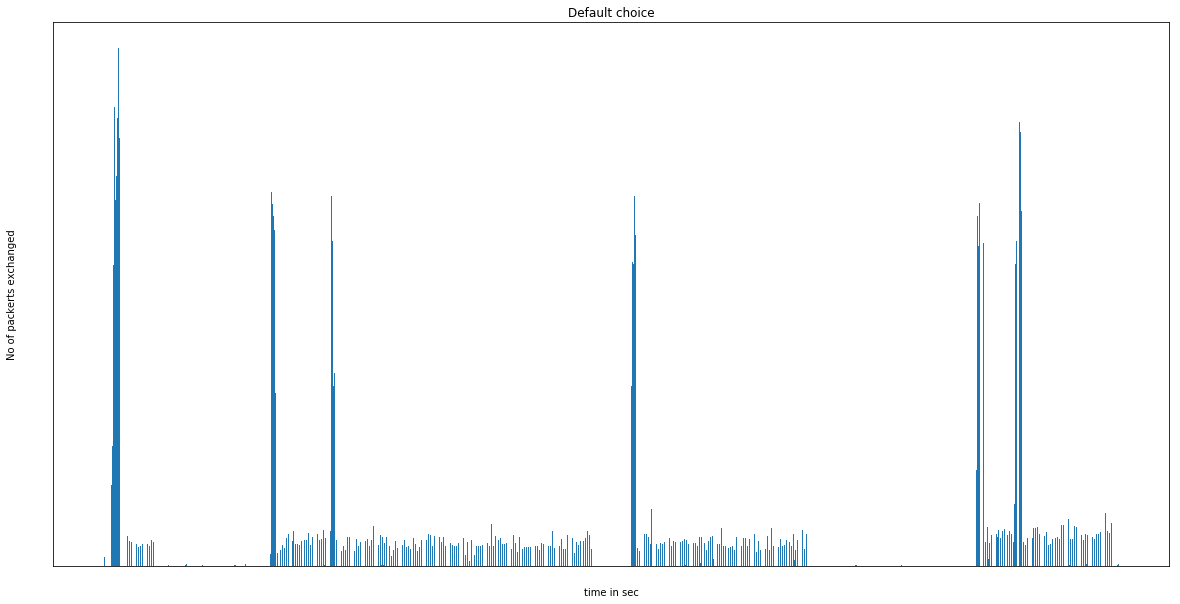

In [5]:
plt.figure(figsize=(20 ,10)) 
plt.bar(d_time, pkt_cnt)
plt.ylabel('No of packerts exchanged')
plt.xlabel('time in sec')
plt.title("Default choice")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()

In [6]:
# Finding peaks
delta = 0
th = 350
peaks =[] # May contain duplicates
for i in range(1,len(pkt_cnt)):
    delta = pkt_cnt[i]-pkt_cnt[i-1]
    if delta > th:
        startTime = d_time[i]
    elif delta < -th:
        endTime = d_time[i]
        peaks.append((startTime, endTime))
print(peaks)

[(20, 26), (164, 168), (164, 170), (219, 224), (494, 500), (812, 815), (812, 819), (850, 854)]


In [7]:
# range with no duplicates
f_peaks = [] # Final peaks with hopefuly no duplicates
for i in range(len(peaks)-1):
    if peaks[i][0] != peaks[i+1][0]:
        f_peaks.append(peaks[i])
f_peaks.append(peaks[i+1])

print(f_peaks)

[(20, 26), (164, 170), (219, 224), (494, 500), (812, 819), (850, 854)]


In [8]:
# filling all unknown ssl.record.length with -1
pcap_main.fillna(-1, inplace=True)
pcap_main.head()

,No.,Time,Source,Destination,Protocol,Length,ssl_len,Info
0,1,0.000000,SuperMic_dc:ba:c7,Broadcast,ARP,60,-1,Who has 192.168.1.163? Tell 192.168.1.248
1,2,0.156770,192.168.1.108,224.0.0.251,MDNS,86,-1,Standard query 0x96e0 PTR _ipfs-discovery._udp...
2,3,0.315904,192.168.1.238,10.6.0.11,DNS,75,-1,Standard query 0x5a83 A www.netflix.com
3,4,0.321660,192.168.1.238,10.6.0.11,DNS,89,-1,Standard query 0x8439 A clientservices.googlea...
4,5,0.323960,10.6.0.11,192.168.1.238,DNS,316,-1,Standard query response 0x8439 A clientservice...


In [9]:
# renaming Length.1(ssl.record.length) to ssllen and Length(packet/frame length) to plen
pcap_main.rename(index=str, columns={"ssl_len": "ssllen", "Length": "plen"}, inplace=True);
pcap_main.shape

(123379, 8)

In [10]:
# Creating new dataframe which contain packet length in between 500 and 700
# temp = pcap_main.query('500<plen<1000')
# temp.shape
# temp.iloc[0:3,:]
# packet length is different for different computers.

In [11]:
temp = pcap_main.query('Info == "Application Data"') # filtering to get only the application data
temp.shape

(5695, 8)

In [12]:
temp['ssllen'] = temp.ssllen.astype(int, copy=False) # converting the ssllen field to integer type
temp = temp.query('6000<ssllen<7000') # filtering to get ssllen in the 6000 to 7000 range.
print(temp.shape)
temp.head()

(63, 8)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,No.,Time,Source,Destination,Protocol,plen,ssllen,Info
1645,1646,5.319722,45.57.51.138,192.168.1.238,TLSv1.2,2932,6217,Application Data
6312,6313,7.735903,45.57.51.138,192.168.1.238,TLSv1.2,2475,6171,Application Data
6707,6708,7.986150,45.57.51.138,192.168.1.238,TLSv1.2,2926,6563,Application Data
8365,8366,9.136865,45.57.51.138,192.168.1.238,TLSv1.2,2719,6629,Application Data
8689,8690,9.834652,192.168.1.238,52.18.15.9,TLSv1.2,360,6081,Application Data


In [13]:
temp = temp.query('Source == "192.168.1.238"') # cl2 are sent from client system
print(temp.shape)
temp.head()

(10, 8)


,No.,Time,Source,Destination,Protocol,plen,ssllen,Info
8689,8690,9.834652,192.168.1.238,52.18.15.9,TLSv1.2,360,6081,Application Data
31587,31588,26.370065,192.168.1.238,52.18.15.9,TLSv1.2,719,6440,Application Data
34477,34478,156.559322,192.168.1.238,52.18.15.9,TLSv1.2,704,6425,Application Data
36674,36675,164.988952,192.168.1.238,52.18.15.9,TLSv1.2,919,6640,Application Data
53529,53530,222.450701,192.168.1.238,52.18.15.9,TLSv1.2,893,6614,Application Data


In [14]:
cl2_cnt = [0]
cl2_time = []
f_no = []
start_time = floor(temp.iloc[0,1])

cl2_time.append(start_time)
i = 0
for _,packet in temp.iterrows():
    f_no.append(packet['No.'])
    curr_time = floor(packet.Time)
    if curr_time > start_time:
        i += 1
        cl2_cnt.append(0)
        cl2_time.append(curr_time)
        start_time = curr_time
    cl2_cnt[i]+= packet['plen']
    
print("cl2 length: {} \ncl2 occurance time: {}".format(cl2_cnt, cl2_time))

cl2 length: [360, 719, 704, 919, 893, 500, 612, 497, 452, 542] 
cl2 occurance time: [9, 26, 156, 164, 222, 498, 814, 851, 911, 939]


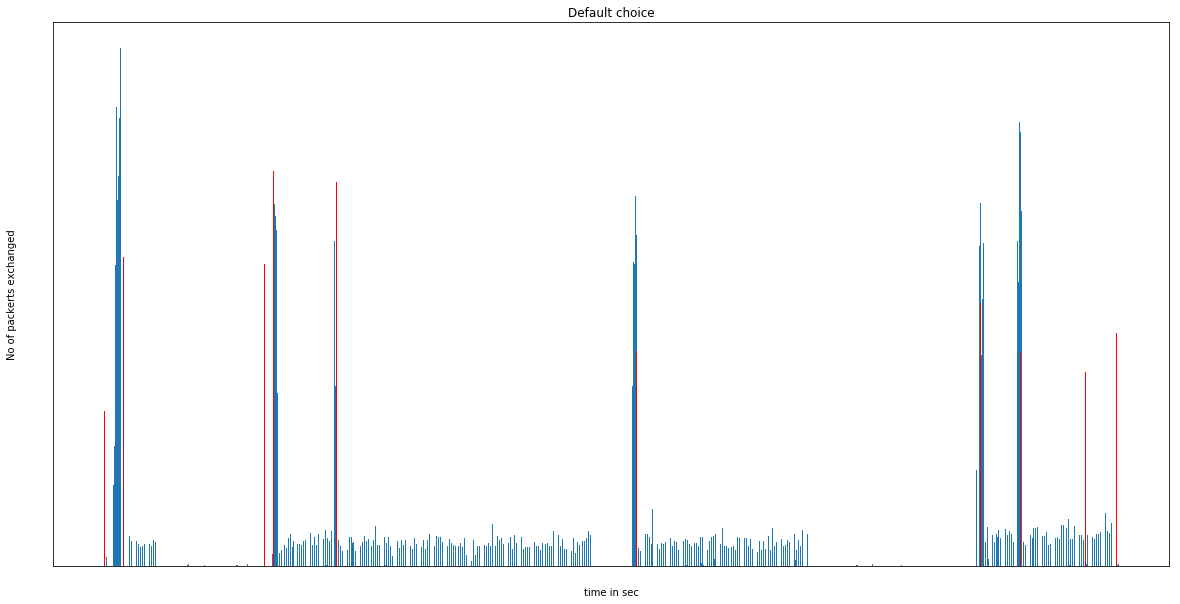

In [15]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.bar(d_time, pkt_cnt)
plt.bar(cl2_time, cl2_cnt, color = 'red')
plt.ylabel('No of packerts exchanged')
plt.xlabel('time in sec')
plt.title("Default choice")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()


In [16]:
# [{'time':x, 'frame_no':y } for x, y in zip(d,f_no)]

In [17]:
final = []
for i in range(len(cl2_time)):
#     print("processing : {}".format(d[i]))
    for peak in f_peaks:
        if cl2_time[i]>= peak[0] and cl2_time[i]<=peak[-1]:
#             print("found in range : {}".format(peak))
            final.append(cl2_time[i])
#         else:
#             print("not found in any range")

In [18]:
print("using only length filter: {} \nfinal cl2's: {}".format(cl2_time, final))

using only length filter: [9, 26, 156, 164, 222, 498, 814, 851, 911, 939] 
final cl2's: [26, 164, 222, 498, 814, 851]


In [23]:
cl2_cnt = [0]
cl2_time = []
f_no = []
start_time = temp.iloc[0,1]

cl2_time.append(start_time)
i = 0
for _,packet in temp.iterrows():
    f_no.append(packet['No.'])
    curr_time = packet.Time
    if curr_time > start_time:
        i += 1
        cl2_cnt.append(0)
        cl2_time.append(curr_time)
        start_time = curr_time
    cl2_cnt[i]+= packet['plen']

In [24]:
print("cl2 length: {} \ncl2 occurance time: {}".format(cl2_cnt, cl2_time))

cl2 length: [360, 719, 704, 919, 893, 500, 612, 497, 452, 542] 
cl2 occurance time: [9.834651876, 26.370064608000003, 156.55932232, 164.98895172299999, 222.45070100599997, 498.216874052, 814.3356791639999, 851.384588631, 911.429744343, 939.976741252]


In [25]:
ll = [[x,y] for x, y in zip(cl2_time,f_no)]
print(ll)

[[9.834651876, 8690], [26.370064608000003, 31588], [156.55932232, 34478], [164.98895172299999, 36675], [222.45070100599997, 53530], [498.216874052, 76590], [814.3356791639999, 94578], [851.384588631, 111949], [911.429744343, 120901], [939.976741252, 123316]]


In [27]:
final_cl2 = []
for l in ll:
#     print("processing : {}".format(l))
    for peak in f_peaks:
        if l[0]>= peak[0] and l[0]<=peak[-1]:
            final_cl2.append(l)
            
print(final_cl2)

[[164.98895172299999, 36675], [222.45070100599997, 53530], [498.216874052, 76590], [814.3356791639999, 94578], [851.384588631, 111949]]
